## Libs

In [1]:
import pandas as pd
import numpy as np 
import joblib
import sys
import matplotlib.pyplot as plt

from fast_ml.model_development import train_valid_test_split

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, confusion_matrix as cm



from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import FeatureImportances

## Extraction

In [2]:
# path to read specific csv data
path = r'C:\Users\erico\Documents\projeto-classificacao\Telco-Customer-Churn\data\WA_Fn-UseC_-Telco-Customer-Churn.csv'
# config path scripts
sys.path.insert(0, r'C:\Users\erico\Documents\projeto-classificacao\Telco-Customer-Churn\scripts')

from extract_data import read_data

df = read_data(path)
df_copy = df.set_index(['customerID']).copy()
df_copy.drop(['gender','PhoneService'], inplace=True, axis=1)

In [3]:
df_copy.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,No,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,No,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,No,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,No,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## train, valid, test split

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_copy, target = 'Churn', train_size=0.8, valid_size=0.1, test_size=0.1)

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_valid shape: ',X_valid.shape)
print('y_valid shape: ',y_valid.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (5634, 17)
y_train shape:  (5634,)
X_valid shape:  (704, 17)
y_valid shape:  (704,)
X_test shape:  (705, 17)
y_test shape:  (705,)


## Feature Selection

In [5]:
num_cols = df_copy.select_dtypes(include=['number']).columns.tolist()

In [6]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [7]:
cat_cols = df_copy.select_dtypes(include=['object']).columns.tolist()[:-1]

In [8]:
cat_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

## Create Pipeline 

In [9]:
preprocessor = ColumnTransformer(
                                transformers=[
                                ('cat', OneHotEncoder(), cat_cols), 
                                ('num', MinMaxScaler(), num_cols)
                                ], remainder="passthrough")

model = LogisticRegression(C=0.1,
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [10]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=300, random_state=42))])

## Training and Validate

In [11]:
# Encoder Target variables
le_Y = LabelEncoder()
y_train = le_Y.fit_transform(y_train)
y_valid = le_Y.transform(y_valid)
y_test = le_Y.transform(y_test)

In [12]:
le_Y.classes_

array(['No', 'Yes'], dtype=object)

In [13]:
# Treina o modelo
model_pipe.fit(X_train, y_train)      
# Faz predições
y_pred = model_pipe.predict(X_valid)
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
# métrica auc
auc = roc_auc_score(y_valid, y_pred)
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(classification_report(y_valid, y_pred))

Recall_CV:0.781 STD: 0.15, AUC: 0.757
              precision    recall  f1-score   support

           0       0.90      0.73      0.80       507
           1       0.53      0.79      0.63       197

    accuracy                           0.74       704
   macro avg       0.71      0.76      0.72       704
weighted avg       0.79      0.74      0.76       704



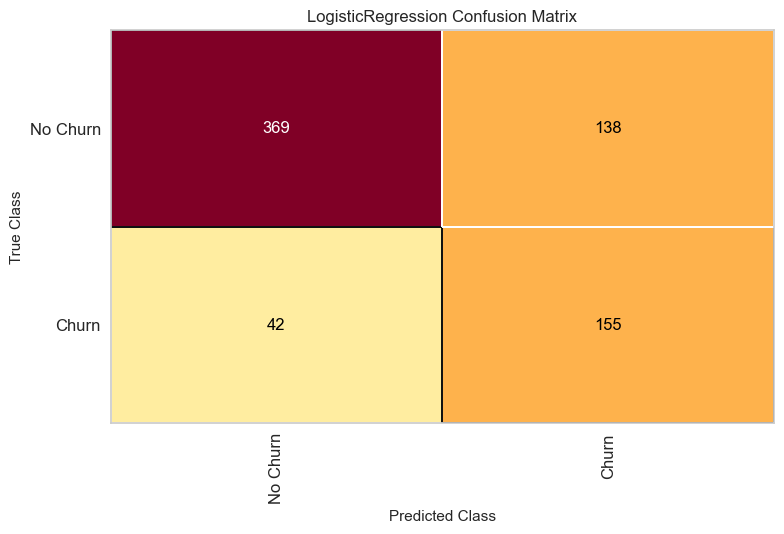

<Figure size 800x550 with 0 Axes>

In [14]:
# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

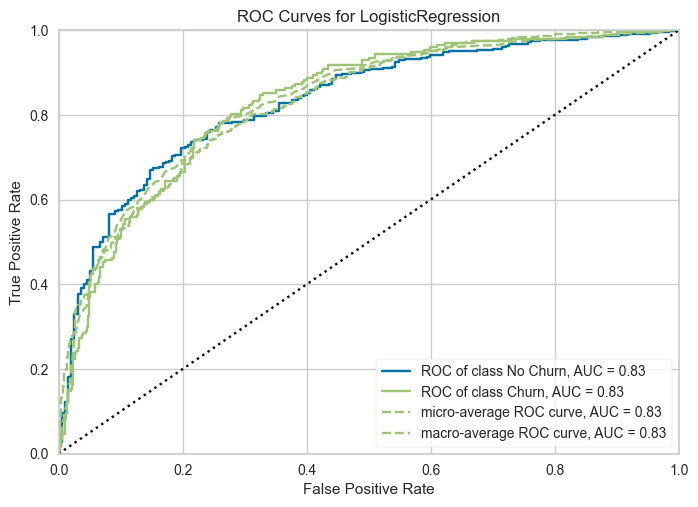

In [15]:
# # Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show();

## Optimization
- GridSearchCV

In [16]:
param_grid = {'model__C': [0.1, 1, 10],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear', 'saga']}

grid_search = GridSearchCV(model_pipe, param_grid, cv=5, scoring='recall')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
0.792350340059707


In [17]:
model = LogisticRegression(C=10,
                           penalty = 'l1',
                           solver = 'liblinear',
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [18]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=300,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [19]:
# Treina o modelo
model_pipe.fit(X_train, y_train)      
# Faz predições
y_pred = model_pipe.predict(X_valid)
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
# métrica auc
auc = roc_auc_score(y_valid, y_pred)
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(classification_report(y_valid, y_pred))

Recall_CV:0.801 STD: 0.13, AUC: 0.764
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       507
           1       0.54      0.80      0.64       197

    accuracy                           0.75       704
   macro avg       0.72      0.76      0.72       704
weighted avg       0.80      0.75      0.76       704



## Test

AUC: 0.782
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       526
           1       0.51      0.83      0.64       179

    accuracy                           0.76       705
   macro avg       0.72      0.78      0.73       705
weighted avg       0.82      0.76      0.77       705



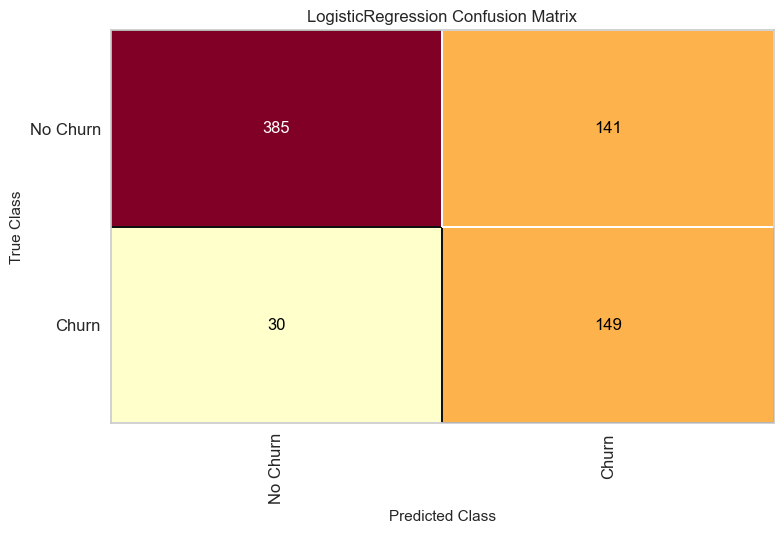

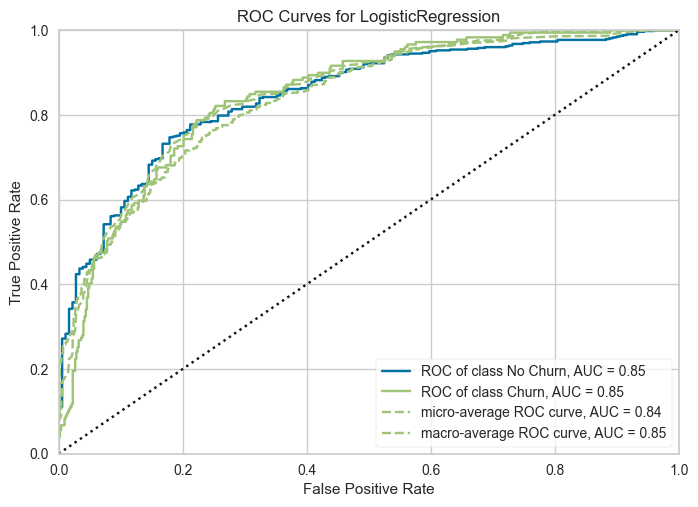

In [20]:
# Faz predições
y_pred = model_pipe.predict(X_test)
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_test, y_pred)
#Exibe as métricas 
print(f"AUC: {auc:.3f}",end="\n")
print(classification_report(y_test, y_pred))

# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_test, y_test,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

# Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show();

## Feature Importance

In [21]:
# ajustar o preprocessor no conjunto de treinamento X_train
X_train_transformed = preprocessor.fit_transform(X_train)
# transformar o conjunto de testes X_test
X_test_transformed = preprocessor.transform(X_test)
# obter o nome das características do ColumnTransformer
cat_encoder = preprocessor.named_transformers_['cat']
cat_cols_transformed = cat_encoder.transform(X_train[cat_cols])
cat_encoder_cols = cat_encoder.get_feature_names(cat_cols)
feature_names = cat_encoder_cols.tolist() + num_cols

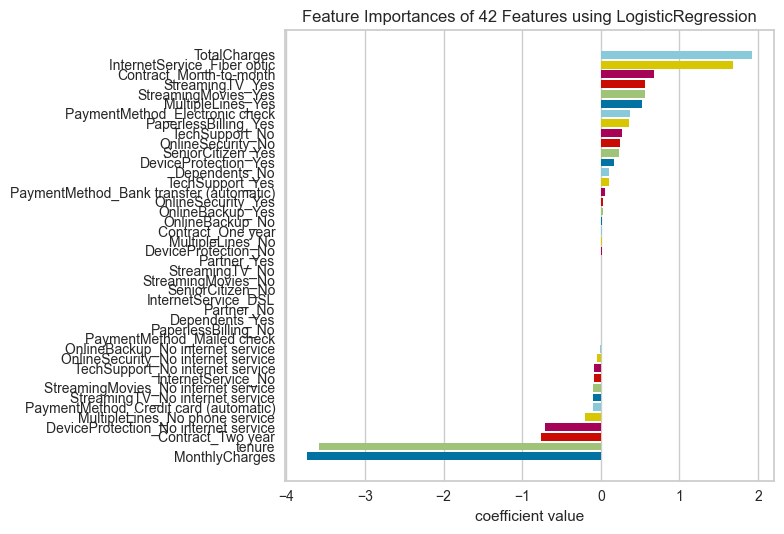

In [22]:
# ajustar a visualização FeatureImportances no modelo logístico ajustado
viz = FeatureImportances(model_pipe.named_steps['model'], labels=feature_names, figsize=(15,8), relative=False)
viz.fit(X_test_transformed, y_test)
viz.show();

## Calculate ROI
- Calculate LTV estimated in period
- Estimate LTV max
- Calculate possible impact from machine learning

### LTV

In [23]:
# Calculate LTV based cust monthly by customer * tenure (monthly before of churn)
df_copy['LTV'] = df_copy['MonthlyCharges'] * df_copy['tenure']

In [24]:
# Value of LTV in the company
print(f'Total LTV actual: R${round(sum(df_copy["LTV"]),2) }')

Total LTV actual: R$16055091.45


In [25]:
# Estimate Max LTV (38) is tenure average if customer not churner
df_copy['LTV Max'] = df_copy.apply(lambda x: x['MonthlyCharges'] * x['tenure'] if x['Churn'] == 'No' else 38 * x['MonthlyCharges'], axis=1)

In [26]:
# Value of LTV in the company
print(f'LTV Max if Churn == 0!: R${round(sum(df_copy["LTV Max"]),2) }')

LTV Max if Churn == 0!: R$18479486.85


In [27]:
# If machine learning model is a sucess the difference is next:
print(f'R${round(sum(df_copy["LTV Max"] - df_copy["LTV"]),2)} ')

R$2424395.4 


### ROI Machine Learning
- To account for both model accuracy and model recall in financial earnings calculations, we can use the confusion matrix to estimate the costs and benefits of each type of classification (true positives, false positives, false negatives, and true negatives). From these values, we can calculate the expected value of lost revenue due to customer evasion and the expected financial gain with a given confidence interval.
- The value 1.96 is a critical number used to calculate the confidence interval for a sample mean with a normal distribution, with a 95% confidence level. The confidence interval is a measure of the uncertainty in estimating the population mean from a random sample. It represents the range of values ​​around the estimated sample mean, within which it is reasonable to say that the actual population mean is contained with a certain probability.

In [28]:
def calcular_ganhos_financeiros(y_true:np.array, y_pred:np.array, custo_evasao:float, custo_aquisicao:float, custo_manutencao:float, numero_clientes_total:int)-> float:
    """
        calculate the expected value of lost revenue due to customer churn and the expected financial gain with a given confidence interval.

        Args:

            y_true (Series) - array of true classes in the data
            y_pred (Series) - array of predict classes from the model
            custo_evasao (float) - the financial cost to the company of losing a customer
            custo_aquisicao (float) - the financial cost for the company to acquire a new customer.
            custo_manutencao (float) - the financial cost for the company to retain a customer.
            numero_clientes_total (int) - the total number of customers in the company's database.

        Returns:
            ganho_esperado_min (float) - minimum impact financial
            ganho_esperado_max (float) - maximum impact financial
    """
    # Calcular a matriz de confusão do modelo
    matriz_confusao = cm(y_true, y_pred)

    # Calcular o número de clientes previstos pelo modelo para evadir e para ficar
    numero_clientes_evasao = matriz_confusao[1, :].sum()
    print(f'Número de clientes em evasão: {numero_clientes_evasao}')
    numero_clientes_ficar = matriz_confusao[0, :].sum()
    print(f'Número de clientes que ficaram: {numero_clientes_ficar}')

    # Calcular o custo e benefício esperado de cada tipo de classificação
    custo_fp = custo_aquisicao * matriz_confusao[0, 1] / numero_clientes_total
    print(f'Custo falso positivo: ${round(custo_fp,2)}')
    custo_fn = custo_evasao * matriz_confusao[1, 0] / numero_clientes_total
    print(f'Custo falso negativo: ${round(custo_fn,2)}')
    beneficio_tp = custo_manutencao * matriz_confusao[0, 0] / numero_clientes_total
    print(f'Beneficio verdadeiro positivo: ${round(beneficio_tp,2)}')
    beneficio_tn = 0
    print(f'Beneficio verdadeiro negativo: ${round(beneficio_tn,2)}')

    # Calcular o valor esperado da receita perdida devido à evasão de clientes
    valor_esperado = custo_fn * numero_clientes_evasao
    print(f'Valor esperado perdido por clientes em churn: ${round(valor_esperado,2)}')

    # Calcular o intervalo de confiança das predições do modelo
    recall = matriz_confusao[1, 1] / (matriz_confusao[1, 1] + matriz_confusao[1, 0])
    print(f'Recall: {round(recall,2)}')
    recall_std = np.sqrt(recall * (1 - recall) / numero_clientes_total)
    print(f'Desvio padrão Recall: {round(recall_std,2)}')
    intervalo_confianca = 1.96 * recall_std
    print(f'Intervalo de confiança: {round(intervalo_confianca,3)}')

    # Calcular o ganho financeiro esperado com 95% de confiança
    ganho_esperado_min = (beneficio_tp - custo_fp) * numero_clientes_ficar - intervalo_confianca * custo_fn * numero_clientes_evasao
    print(f'Ganho financeiro mínimo: ${round(ganho_esperado_min,2)}')
    ganho_esperado_max = (beneficio_tp - custo_fp) * numero_clientes_ficar + intervalo_confianca * custo_fn * numero_clientes_evasao
    print(f'Ganho financeiro máximo: ${round(ganho_esperado_max,2)}')

    return ganho_esperado_min, ganho_esperado_max


In [29]:
# the data of financial costs

# ( Possible LTV Max - LTV actual ) / Number of clientes churned in database
custo_evasao = round( sum(df_copy["LTV Max"] - df_copy["LTV"]) / df_copy[df_copy['Churn']=='Yes'].shape[0], 2)
# (CAC) estimated for Telco SA
custo_aquisicao = 500
# Estimated cust for mantain customer in the company
custo_manutencao = 200
# Number of total clientes in the database of Telco SA
numero_clientes_total = df_copy.shape[0]

# Calculate financial impacts know
min_, max_ = calcular_ganhos_financeiros(y_true=y_test, 
                                        y_pred=y_pred, 
                                        custo_evasao=custo_evasao,
                                        custo_aquisicao=custo_aquisicao,
                                        custo_manutencao=custo_manutencao,
                                        numero_clientes_total=numero_clientes_total)

Número de clientes em evasão: 179
Número de clientes que ficaram: 526
Custo falso positivo: $10.01
Custo falso negativo: $5.53
Beneficio verdadeiro positivo: $10.93
Beneficio verdadeiro negativo: $0
Valor esperado perdido por clientes em churn: $989.03
Recall: 0.83
Desvio padrão Recall: 0.0
Intervalo de confiança: 0.009
Ganho financeiro mínimo: $476.82
Ganho financeiro máximo: $494.07


# Deploy

In [30]:
with open(r'C:\Users\erico\Documents\projeto-classificacao\Telco-Customer-Churn\models\model.pkl', 'wb') as f:
    joblib.dump(model_pipe, f)

In [31]:
with open(r'C:\Users\erico\Documents\projeto-classificacao\Telco-Customer-Churn\models\model.pkl', 'rb') as f:
    model = joblib.load(f)

In [32]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=300,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

# Test API server

In [33]:
import json
import requests

In [34]:
# test_api = X_test.sample(2)
# test_api = test_api.reset_index()

# url = 'http://127.0.0.1:5000/predict'
# request_data = json.dumps(test_api.to_dict(orient='records'))
# header = {'Content-type': 'application/json' } 
# response = requests.post(url, request_data, headers=header)
# print(f'Status Code: {response.status_code}')
# print(response.text)

In [35]:
# result_api = response.json()
# df_result = pd.DataFrame(result_api)

In [36]:
#df_result

# MLOps

In [53]:
from evidently import ColumnMapping
from evidently.test_suite import TestSuite
from evidently.dashboard import Dashboard
from evidently.report import Report
from evidently.metric_preset import ClassificationPreset
from evidently.dashboard.tabs import ProbClassificationPerformanceTab

from evidently.test_preset import BinaryClassificationTestPreset

## Prepare reference

In [38]:
X_valid.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,,,,,,,,,,,
2115-BFTIW,No,No,No,25,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Mailed check,70.95,1767.35
5451-YHYPW,Yes,Yes,No,72,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),115.75,8443.70
0363-QJVFX,No,No,No,32,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),108.15,3432.90
4945-RVMTE,No,No,No,28,No,DSL,No,No,Yes,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),59.55,1646.45
9578-FOMUK,No,No,Yes,15,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,24.80,324.15


In [39]:
# get predictions (reference)
X_valid['No'] = model.predict_proba(X_valid)[:,0]
X_valid['prediction'] = model.predict_proba(X_valid)[:,1]

X_valid['Probability'] = model.predict_proba(X_valid)[:,1]
X_valid['Prediction'] = model.predict(X_valid)

In [40]:
# # get prescription 
X_valid["Probability"] = np.around(X_valid['Probability'], decimals=2)

X_valid["Prescription"] = np.where(X_valid['Probability'] >= 0.70, "High Potential Churn - Red alert",
                    np.where(X_valid['Probability'] >= 0.50, "Moderate Potential Churn - Yellow alert", "No Potential Churn"))

In [41]:
X_valid.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,No,prediction,Probability,Prediction,Prescription
customerID,,,,,,,,,,,,,,,,,,,,,
2115-BFTIW,No,No,No,25,No,Fiber optic,No,No,No,No,...,Month-to-month,No,Mailed check,70.95,1767.35,0.441921,0.558079,0.56,1,Moderate Potential Churn - Yellow alert
5451-YHYPW,Yes,Yes,No,72,Yes,Fiber optic,Yes,Yes,Yes,Yes,...,Two year,Yes,Credit card (automatic),115.75,8443.70,0.862781,0.137219,0.14,0,No Potential Churn
0363-QJVFX,No,No,No,32,Yes,Fiber optic,Yes,Yes,No,Yes,...,Month-to-month,Yes,Credit card (automatic),108.15,3432.90,0.408926,0.591074,0.59,1,Moderate Potential Churn - Yellow alert
4945-RVMTE,No,No,No,28,No,DSL,No,No,Yes,No,...,Month-to-month,Yes,Bank transfer (automatic),59.55,1646.45,0.519961,0.480039,0.48,0,No Potential Churn
9578-FOMUK,No,No,Yes,15,Yes,No,No internet service,No internet service,No internet service,No internet service,...,Month-to-month,Yes,Electronic check,24.80,324.15,0.528821,0.471179,0.47,0,No Potential Churn


## Prepare current

In [42]:
# load test 
test_df = pd.read_csv(r'C:\Users\erico\Documents\projeto-classificacao\Telco-Customer-Churn\data\teste_prod.csv')

In [43]:
# Transform raw data
test_df['SeniorCitizen'] = test_df['SeniorCitizen'].map({0:'No',1:'Yes'})
test_df = test_df.set_index(['customerID']).copy()
test_df.drop(['gender','PhoneService'], inplace=True, axis=1)

In [44]:
test_df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,
1035-IPQPU,Yes,Yes,No,63,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,103.50,6479.40,No
7398-LXGYX,No,Yes,No,44,Yes,Fiber optic,Yes,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),84.80,3626.35,No
2823-LKABH,No,No,No,18,Yes,Fiber optic,No,No,Yes,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.40,No
8775-CEBBJ,No,No,No,9,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes
0550-DCXLH,No,No,No,13,No,DSL,No,Yes,No,Yes,Yes,Yes,Month-to-month,No,Mailed check,73.35,931.55,No


In [45]:
# get predictions (current)
test_df['No'] = model.predict_proba(test_df)[:,0]
test_df['Yes'] = model.predict_proba(test_df)[:,1]

test_df['Probability'] = model.predict_proba(test_df)[:,1]
test_df['Prediction'] = model.predict(test_df)

In [46]:
test_df

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,No,Yes,Probability,Prediction
customerID,,,,,,,,,,,,,,,,,,,,,
1035-IPQPU,Yes,Yes,No,63,Yes,Fiber optic,No,Yes,Yes,No,...,Month-to-month,Yes,Electronic check,103.50,6479.40,No,0.282394,0.717606,0.717606,1
7398-LXGYX,No,Yes,No,44,Yes,Fiber optic,Yes,No,Yes,No,...,Month-to-month,Yes,Credit card (automatic),84.80,3626.35,No,0.526148,0.473852,0.473852,0
2823-LKABH,No,No,No,18,Yes,Fiber optic,No,No,Yes,Yes,...,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.40,No,0.243106,0.756894,0.756894,1
8775-CEBBJ,No,No,No,9,No,DSL,No,No,No,No,...,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes,0.391905,0.608095,0.608095,1
0550-DCXLH,No,No,No,13,No,DSL,No,Yes,No,Yes,...,Month-to-month,No,Mailed check,73.35,931.55,No,0.543929,0.456071,0.456071,0
9281-CEDRU,No,Yes,No,68,No,DSL,No,Yes,No,Yes,...,Two year,No,Bank transfer (automatic),64.10,4326.25,No,0.977191,0.022809,0.022809,0
2235-DWLJU,Yes,No,No,6,No phone service,DSL,No,No,No,No,...,Month-to-month,Yes,Electronic check,44.40,263.05,No,0.118559,0.881441,0.881441,1
0871-OPBXW,No,No,No,2,No,No,No internet service,No internet service,No internet service,No internet service,...,Month-to-month,Yes,Mailed check,20.05,39.25,No,0.533998,0.466002,0.466002,0
3605-JISKB,Yes,Yes,No,55,Yes,DSL,Yes,Yes,No,No,...,One year,No,Credit card (automatic),60.00,3316.10,No,0.919295,0.080705,0.080705,0


In [47]:
# get prescription 
test_df["Probability"] = np.around(test_df['Probability'], decimals=2)

test_df["Prescription"] = np.where(test_df['Probability'] >= 0.70, "High Potential Churn - Red alert",
                    np.where(test_df['Probability'] >= 0.50, "Moderate Potential Churn - Yellow alert", "No Potential Churn"))

In [48]:
test_df.tail()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,No,Yes,Probability,Prediction,Prescription
customerID,,,,,,,,,,,,,,,,,,,,,
6840-RESVB,No,Yes,Yes,24,Yes,DSL,Yes,No,Yes,Yes,...,Yes,Mailed check,84.80,1990.50,No,0.706496,0.293504,0.29,0,No Potential Churn
2234-XADUH,No,Yes,Yes,72,Yes,Fiber optic,No,Yes,Yes,No,...,Yes,Credit card (automatic),103.20,7362.90,No,0.687706,0.312294,0.31,0,No Potential Churn
4801-JZAZL,No,Yes,Yes,11,No phone service,DSL,Yes,No,No,No,...,Yes,Electronic check,29.60,346.45,No,0.341747,0.658253,0.66,1,Moderate Potential Churn - Yellow alert
8361-LTMKD,Yes,Yes,No,4,Yes,Fiber optic,No,No,No,No,...,Yes,Mailed check,74.40,306.60,Yes,0.126892,0.873108,0.87,1,High Potential Churn - Red alert
3186-AJIEK,No,No,No,66,No,Fiber optic,Yes,No,Yes,Yes,...,Yes,Bank transfer (automatic),105.65,6844.50,No,0.892674,0.107326,0.11,0,No Potential Churn


## Evidently AI

In [49]:
column_mapping = ColumnMapping()

column_mapping.target = 'Churn'
column_mapping.prediction = ['No', 'Yes']

In [54]:
dashboard = Dashboard(tabs=[ProbClassificationPerformanceTab()])
dashboard.calculate(test_df, column_mapping = column_mapping)
dashboard.show()